In [18]:
import numpy as np
import magpylib as magpy
from magpylib import Collection

In [ ]:
def make_coil(current, num_coils, coil_spacing, position, diameter=0.01):
    x, y, z = position
    coils = []
    for i in range(num_coils):
        coil = magpy.current.Circle(
            current=current,
            diameter=diameter,
            position=(x, y, z - i * coil_spacing)
        )
        coils.append(coil)
    return coils

def construct_system(x_current, y_current):
    """
    Constructs a full magnetic coil system with 4 symmetric coil pillars.
    Each pillar is made of stacked coils with varying diameters.
    
    Currents are applied as:
      - X pillars: +x_current and -x_current
      - Y pillars: +y_current and -y_current
    """
    coil_pillars = []
    spacing = 0.027 / 2

    # Positions for the 4 pillars (forming a square)
    x1_pos = (-spacing, -spacing, 0)
    x2_pos = (spacing, spacing, 0)
    y1_pos = (spacing, -spacing, 0)
    y2_pos = (-spacing, spacing, 0)

    # Coil diameters, from large to small
    diameter_values = np.linspace(0.007, 0.019, 34)[::-1]

    for diameter in diameter_values:
        coil_pillars.extend(make_coil(-x_current, 30, 0.00033, x1_pos, diameter))
        coil_pillars.extend(make_coil(x_current, 30, 0.00033, x2_pos, diameter))
        coil_pillars.extend(make_coil(y_current, 30, 0.00033, y1_pos, diameter))
        coil_pillars.extend(make_coil(-y_current, 30, 0.00033, y2_pos, diameter))

    return Collection(coil_pillars)

def compute_gradient_vectorized(source, position, delta=0.001):
    x, y, z = position
    positions = np.array([
        [x + delta, y, z],
        [x - delta, y, z],
        [x, y + delta, z],
        [x, y - delta, z],
        [x, y, z + delta],
        [x, y, z - delta]
    ])
    B_fields = source.getB(positions)

    dBx_dx = (B_fields[0, 0] - B_fields[1, 0]) / (2 * delta)
    dBy_dy = (B_fields[2, 1] - B_fields[3, 1]) / (2 * delta)
    dBz_dz = (B_fields[4, 2] - B_fields[5, 2]) / (2 * delta)

    return dBx_dx, dBy_dy, dBz_dz

In [20]:
# Example: evaluate at center for 5A in X and 3A in Y
x_current = 5.0
y_current = 5.0
position = (0.0, 0.01, 0.03)

system = construct_system(x_current, y_current)
dBx_dx, dBy_dy, dBz_dz = compute_gradient_vectorized(system, position)

print(f"Gradient at {position} for Ix={x_current} A, Iy={y_current} A:")
print(f"  dBx/dx = {dBx_dx:.6e} T/m")
print(f"  dBy/dy = {dBy_dy:.6e} T/m")
print(f"  dBz/dz = {dBz_dz:.6e} T/m")

Gradient at (0.0, 0.01, 0.03) for Ix=5.0 A, Iy=5.0 A:
  dBx/dx = -2.678057e-02 T/m
  dBy/dy = -2.252058e-01 T/m
  dBz/dz = 2.526666e-01 T/m


In [25]:
magnetic_moment = 2.06
force = dBx_dx * magnetic_moment, dBy_dy * magnetic_moment, dBz_dz * magnetic_moment
print(f"Force on magnetic moment: {force[0]:.3e}, {force[1]:.3e}, {force[2]:.3e} N")


Force on magnetic moment: -5.517e-02, -4.639e-01, 5.205e-01 N


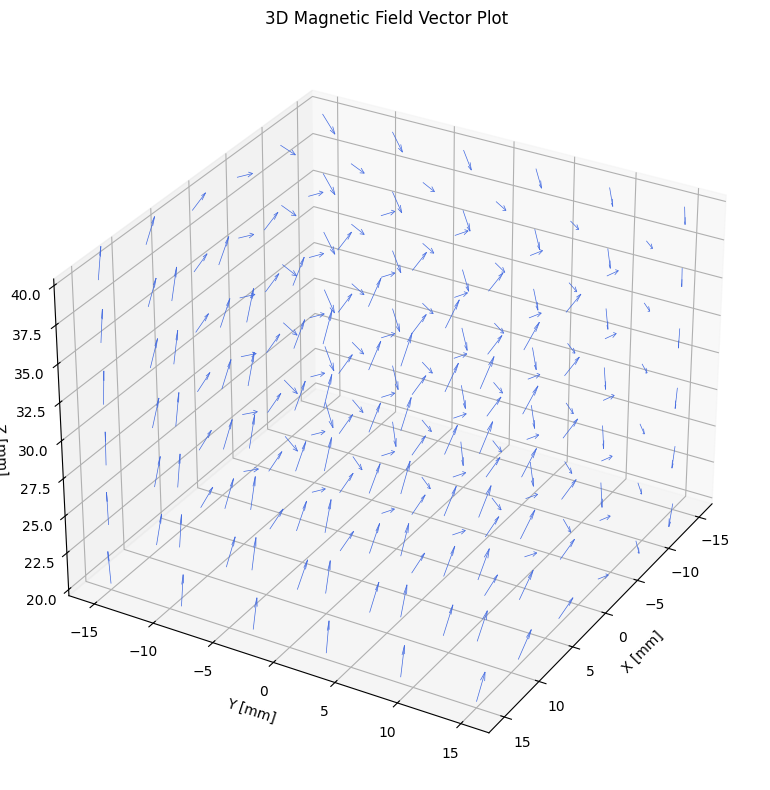

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# -- Coil System --
x_current = -5.0
y_current = 5.0
system = construct_system(x_current, y_current)

# -- 3D Grid Setup --
grid_size = 6  # Keep small for visibility; increase for finer detail
xy_range = 0.015  # ±1.5 cm
z_range = (0.02, 0.04)

x_vals = np.linspace(-xy_range, xy_range, grid_size)
y_vals = np.linspace(-xy_range, xy_range, grid_size)
z_vals = np.linspace(z_range[0], z_range[1], grid_size)

X, Y, Z = np.meshgrid(x_vals, y_vals, z_vals)
positions = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))

# -- Compute Magnetic Field Vectors --
B = system.getB(positions)
Bx, By, Bz = B[:, 0], B[:, 1], B[:, 2]
B_magnitude = np.linalg.norm(B, axis=1)

# -- Normalize vectors for consistent arrow length --
# (otherwise long arrows dominate the view)
norm = B_magnitude + 1e-12  # avoid division by zero
Ux = Bx / norm
Uy = By / norm
Uz = Bz / norm

# -- 3D Vector Field Plot --
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scale position to mm for display
ax.quiver(
    positions[:, 0]*1000, positions[:, 1]*1000, positions[:, 2]*1000,
    Ux, Uy, Uz,
    length=2, normalize=False, color='royalblue', linewidth=0.5
)

# Optional: show color based on field strength
# sc = ax.scatter(positions[:, 0]*1000, positions[:, 1]*1000, positions[:, 2]*1000,
#                 c=B_magnitude*1e3, cmap='plasma', s=5)
# fig.colorbar(sc, ax=ax, label='|B| [mT]')

ax.set_xlabel('X [mm]')
ax.set_ylabel('Y [mm]')
ax.set_zlabel('Z [mm]')
ax.set_title('3D Magnetic Field Vector Plot')
ax.view_init(elev=30, azim=30)
plt.tight_layout()
plt.show()


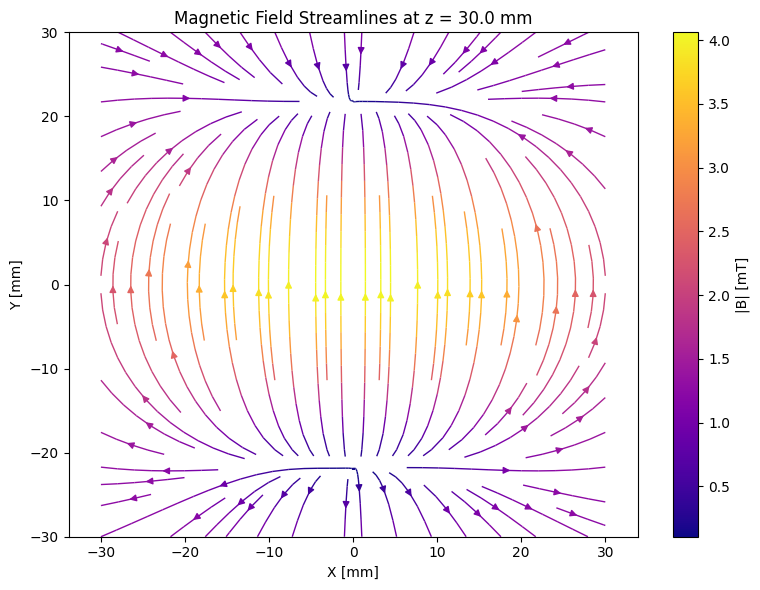

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# --- Define system ---
x_current = 5.0
y_current = 5.0
system = construct_system(x_current, y_current)

# --- Grid (2D slice) ---
grid_size = 40
xy_range = 0.03  # ±1.5 cm
z_plane = 0.03  # 3 cm height

x_vals = np.linspace(-xy_range, xy_range, grid_size)
y_vals = np.linspace(-xy_range, xy_range, grid_size)
X, Y = np.meshgrid(x_vals, y_vals)
positions = np.column_stack((X.ravel(), Y.ravel(), np.full(X.size, z_plane)))

# --- Compute B field ---
B = system.getB(positions)
Bx = B[:, 0].reshape(X.shape)
By = B[:, 1].reshape(Y.shape)
Bmag = np.linalg.norm(B[:, :2], axis=1).reshape(X.shape)

# --- Stream plot ---
plt.figure(figsize=(8, 6))
strm = plt.streamplot(X*1000, Y*1000, Bx, By, color=Bmag*1e3, cmap='plasma', linewidth=1)
plt.colorbar(strm.lines, label='|B| [mT]')
plt.title(f'Magnetic Field Streamlines at z = {z_plane*1000:.1f} mm')
plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')
plt.axis('equal')
plt.tight_layout()
plt.show()


In [34]:
import plotly.graph_objects as go

# Sample fewer points for clarity
x_vals = np.linspace(-xy_range, xy_range, 6)
y_vals = np.linspace(-xy_range, xy_range, 6)
z_vals = np.linspace(0.02, 0.04, 6)

X, Y, Z = np.meshgrid(x_vals, y_vals, z_vals)
positions = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))
B = system.getB(positions)
Bx, By, Bz = B[:, 0], B[:, 1], B[:, 2]

fig = go.Figure(data=go.Cone(
    x=positions[:, 0]*1000, y=positions[:, 1]*1000, z=positions[:, 2]*1000,
    u=Bx, v=By, w=Bz,
    colorscale='Plasma',
    sizemode="absolute",
    sizeref=5e-3,
    showscale=True,
    colorbar_title="Field Strength [T]"
))

fig.update_layout(
    title='3D Magnetic Field Vector Flow',
    scene=dict(
        xaxis_title='X [mm]',
        yaxis_title='Y [mm]',
        zaxis_title='Z [mm]',
        aspectmode='cube',
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)
fig.show()


In [41]:
import numpy as np
import plotly.graph_objects as go

# Grid setup
grid_size = 6
xy_range = 0.015
z_vals = np.linspace(0.02, 0.04, grid_size)
x_vals = np.linspace(-xy_range, xy_range, grid_size)
y_vals = np.linspace(-xy_range, xy_range, grid_size)

X, Y, Z = np.meshgrid(x_vals, y_vals, z_vals)
positions = np.column_stack((X.ravel(), Y.ravel(), Z.ravel()))

# Compute magnetic field
B = system.getB(positions)
Bx, By, Bz = B[:, 0], B[:, 1], B[:, 2]
B_mag = np.linalg.norm(B, axis=1)

# Normalize vectors for direction only
B_unit = B / (B_mag[:, np.newaxis] + 1e-12)

# Scale cone sizes for visibility (e.g., based on mT)
scaled_strength = B_mag * 1e3  # convert T -> mT for intuitive sizing

# Set cone size reference (you can tweak this if arrows are too big/small)
sizeref = np.percentile(scaled_strength, 90) / 15

# Build figure
fig = go.Figure(data=go.Cone(
    x=positions[:, 0]*1000,  # mm
    y=positions[:, 1]*1000,
    z=positions[:, 2]*1000,
    u=B_unit[:, 0],
    v=B_unit[:, 1],
    w=B_unit[:, 2],
    colorbar_title="|B| [mT]",
    colorscale='Plasma',
    cmin=scaled_strength.min(),
    cmax=scaled_strength.max(),
    showscale=True,
    sizemode="scaled",
    sizeref=sizeref,
    anchor="tail",
    hovertext=[f"|B| = {m:.2f} mT" for m in scaled_strength],
    hoverinfo="text"
))

# Layout tweaks
fig.update_layout(
    title='3D Magnetic Field Vectors (Normalized Direction, Colored by Strength)',
    scene=dict(
        xaxis_title='X [mm]',
        yaxis_title='Y [mm]',
        zaxis_title='Z [mm]',
        aspectmode='cube',
        camera=dict(eye=dict(x=1.3, y=1.3, z=0.8))
    ),
    margin=dict(l=0, r=0, t=40, b=0)
)

fig.show()


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from mpl_toolkits.mplot3d import Axes3D

def construct_system(x_current, y_current):
    coil_pillars = []
    spacing = 0.027 / 2
    x1_pos = (-spacing, -spacing, 0)
    x2_pos = (spacing, spacing, 0)
    y1_pos = (spacing, -spacing, 0)
    y2_pos = (-spacing, spacing, 0)
    diameter_values = np.linspace(0.007, 0.019, 34)[::-1]

    for diameter in diameter_values:
        coil_pillars.extend(make_coil(x_current, 30, 0.00033, x1_pos, diameter))
        coil_pillars.extend(make_coil(-x_current, 30, 0.00033, x2_pos, diameter))
        coil_pillars.extend(make_coil(y_current, 30, 0.00033, y1_pos, diameter))
        coil_pillars.extend(make_coil(-y_current, 30, 0.00033, y2_pos, diameter))

    return magpy.Collection(coil_pillars)

def trace_field_line(system, seed, direction=1, max_length=0.1, step_size=0.0005):
    def ode(t, pos):
        B = system.getB(pos)
        norm = np.linalg.norm(B)
        if norm == 0:
            return [0, 0, 0]
        return direction * B / norm

    sol = solve_ivp(
        ode,
        t_span=(0, max_length),
        y0=seed,
        max_step=step_size,
        rtol=1e-6,
        atol=1e-9
    )
    return sol.y.T  # Transpose to get shape (N, 3)

# Initialize system
x_current = 5.0
y_current = 5.0
system = construct_system(x_current, y_current)

# Define seed points (slightly above center)
seeds = [
    [0.005, 0, 0.03],
    [-0.005, 0, 0.03],
    [0, 0.005, 0.03],
    [0, -0.005, 0.03],
    [0.005, 0.005, 0.03],
    [-0.005, -0.005, 0.03],
]

# Trace lines (forward and backward)
field_lines = []
for seed in seeds:
    fwd = trace_field_line(system, seed, direction=1)
    bwd = trace_field_line(system, seed, direction=-1)
    field_lines.append(np.vstack((bwd[::-1], fwd)))  # Combine backward and forward

# Plot field lines
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for line in field_lines:
    ax.plot(line[:, 0]*1000, line[:, 1]*1000, line[:, 2]*1000, lw=1.5)

ax.set_xlabel("X [mm]")
ax.set_ylabel("Y [mm]")
ax.set_zlabel("Z [mm]")
ax.set_title("Magnetic Field Lines (from coils)")
ax.view_init(elev=30, azim=45)
ax.set_box_aspect([1, 1, 1])
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

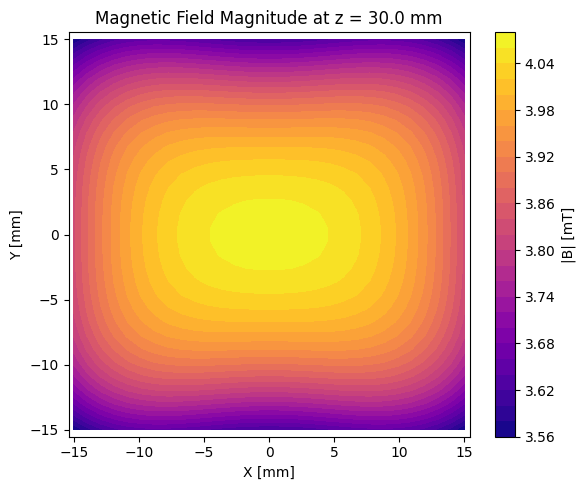

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Use the system you've built
x_current = -5.0
y_current = 5.0
z_plane = 0.03  # meters

system = construct_system(x_current, y_current)

# Create a grid of (x, y) positions
grid_size = 30
xy_range = 0.015  # ±1.5 cm
x_vals = np.linspace(-xy_range, xy_range, grid_size)
y_vals = np.linspace(-xy_range, xy_range, grid_size)
X, Y = np.meshgrid(x_vals, y_vals)
positions = np.column_stack((X.ravel(), Y.ravel(), np.full(X.size, z_plane)))

# Compute B-field at all positions
B = system.getB(positions)
B_magnitude = np.linalg.norm(B, axis=1).reshape(X.shape)

# Plot the B-field magnitude
plt.figure(figsize=(6, 5))
plt.contourf(X * 1000, Y * 1000, B_magnitude * 1e3, levels=30, cmap='plasma')
plt.colorbar(label='|B| [mT]')
plt.xlabel('X [mm]')
plt.ylabel('Y [mm]')
plt.title(f'Magnetic Field Magnitude at z = {z_plane*1000:.1f} mm')
plt.axis('equal')
plt.tight_layout()
plt.show()


In [22]:
'''
import csv

# Define ranges
current_list = np.linspace(0, 10, 6)  # 0 to 10 A in 6 steps
x_vals = np.linspace(-0.01, 0.01, 5)
y_vals = np.linspace(-0.01, 0.01, 5)
z = 0.3

with open("gradient_data.csv", mode='w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["current", "x", "y", "z", "dBx_dx", "dBy_dy", "dBz_dz"])

    for current in current_list:
        print(f"Current: {current} A")
        system = construct_system(current)

        for x in x_vals:
            for y in y_vals:
                position = (x, y, z)
                dBx_dx, dBy_dy, dBz_dz = compute_gradient_vectorized(system, position)

                writer.writerow([
                    round(current, 2), round(x, 4), round(y, 4), round(z, 4),
                    dBx_dx, dBy_dy, dBz_dz
                ])
'''

'\nimport csv\n\n# Define ranges\ncurrent_list = np.linspace(0, 10, 6)  # 0 to 10 A in 6 steps\nx_vals = np.linspace(-0.01, 0.01, 5)\ny_vals = np.linspace(-0.01, 0.01, 5)\nz = 0.3\n\nwith open("gradient_data.csv", mode=\'w\', newline=\'\') as csvfile:\n    writer = csv.writer(csvfile)\n    writer.writerow(["current", "x", "y", "z", "dBx_dx", "dBy_dy", "dBz_dz"])\n\n    for current in current_list:\n        print(f"Current: {current} A")\n        system = construct_system(current)\n\n        for x in x_vals:\n            for y in y_vals:\n                position = (x, y, z)\n                dBx_dx, dBy_dy, dBz_dz = compute_gradient_vectorized(system, position)\n\n                writer.writerow([\n                    round(current, 2), round(x, 4), round(y, 4), round(z, 4),\n                    dBx_dx, dBy_dy, dBz_dz\n                ])\n'